In [6]:

import pandas as pd #
import numpy as np
from joblib import load
from sklearn.decomposition import PCA
from scipy.spatial.distance import mahalanobis
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns

#crit_thresh = -0.080239
#warn_thresh = -0.030199
crit_thresh = -0.097692
warn_thresh = -0.045423

# Load Isolation Forest model and scaler
scaler = load('./model/iso_scaler2.joblib')
iso_model = load('./model/iso_model2.joblib')

# Load datasets
df_val = pd.read_excel("./../../data/test.xlsx")
df_val = df_val.sort_values('timestamp').reset_index(drop=True)

In [7]:
df_val['label'] = df_val['label'].fillna('Normal')
df_val

,timestamp,devID,soil,rain,temp,humi,geo,label
0,2025-07-24T17:10:00,101,48.73,0.00,30.31,74.72,3.46,Normal
1,2025-07-24T17:10:10,101,49.25,0.00,29.89,75.31,5.21,Normal
2,2025-07-24T17:10:20,101,48.19,0.00,30.42,74.68,4.19,Normal
3,2025-07-24T17:10:30,101,48.58,0.00,29.68,75.95,3.93,Normal
4,2025-07-24T17:10:40,101,47.88,0.00,30.15,75.52,5.88,Normal
...,...,...,...,...,...,...,...,...
188,2025-07-24T17:41:20,101,78.48,38.11,27.98,69.70,13.52,critical
189,2025-07-24T17:41:30,101,78.89,30.21,27.96,69.30,27.42,critical
190,2025-07-24T17:41:40,101,79.31,36.21,27.94,68.90,13.13,critical
191,2025-07-24T17:41:50,101,79.73,34.84,27.92,68.50,11.75,critical


In [8]:
#df_val  = pd.concat([df1, df2], ignore_index=True)
df_val.describe()

,devID,soil,rain,temp,humi,geo
count,193.0,193.000000,193.000000,193.000000,193.000000,193.000000
mean,101.0,54.799637,12.795751,29.507617,77.332746,10.141036
std,0.0,9.739599,16.827212,0.741557,4.816547,8.379583
min,101.0,47.520000,0.000000,27.890000,68.100000,3.010000
25%,101.0,48.390000,0.000000,28.930000,74.920000,4.250000
50%,101.0,49.030000,0.000000,29.700000,75.640000,5.300000
75%,101.0,60.140000,33.160000,30.120000,77.300000,13.750000
max,101.0,80.140000,39.840000,30.490000,91.700000,29.980000


In [9]:
print(df_val['label'].value_counts())

label
Normal      121
critical     70
warning       2
Name: count, dtype: int64


## Threshold

In [10]:
# แปลง timestamp เป็น datetime หากยังไม่ได้แปลง
df_val['timestamp'] = pd.to_datetime(df_val['timestamp'])

# สร้างคอลัมน์ hour
df_val['hour'] = df_val['timestamp'].dt.hour

# สร้าง features
feature_cols = ['soil', 'rain', 'temp', 'humi', 'geo']
X_val = df_val[feature_cols].values
X_val_scaled = scaler.transform(X_val)

# คำนวณ anomaly score และจัดระดับความเสี่ยง
df_val['anomaly_score'] = iso_model.decision_function(X_val_scaled)


#crit_thresh = np.percentile(df_val['anomaly_score'], 0.25)
#warn_thresh = np.percentile(df_val['anomaly_score'], 0.75)
#crit_thresh = -0.094870
#warn_thresh = -0.042534

def classify_risk(score):
    if score < crit_thresh:
        return "Critical"
    elif score < warn_thresh:
        return "Warning"
    else:
        return "Normal"

df_val['predicted_risk'] = df_val['anomaly_score'].apply(classify_risk)
print("Risk levels ('Critical', 'Warning', 'Normal') assigned based on anomaly scores.")

print("\nPredicted Risk Distribution:")
print(df_val['predicted_risk'].value_counts())

print("\nLabel Distribution:")
print(df_val['label'].value_counts())

#print("crit_thresh:", np.percentile(df_val['anomaly_score'], 0.4))
#print("warn_thresh:", np.percentile(df_val['anomaly_score'], 1))

Risk levels ('Critical', 'Warning', 'Normal') assigned based on anomaly scores.

Predicted Risk Distribution:
predicted_risk
Normal      121
Critical     70
Warning       2
Name: count, dtype: int64

Label Distribution:
label
Normal      121
critical     70
warning       2
Name: count, dtype: int64


In [11]:
critical_group = df_val[df_val['anomaly_score'] < crit_thresh]
print("critical_group")
print(critical_group[feature_cols].describe())

critical_group
            soil       rain       temp       humi        geo
count  70.000000  70.000000  70.000000  70.000000  70.000000
mean   65.760571  34.829714  28.645286  80.617429  19.763143
std     8.492741   2.996436   0.450619   6.823561   6.739605
min    51.120000  24.500000  27.890000  68.100000   9.600000
25%    58.582500  32.320000  28.265000  75.000000  13.537500
50%    65.770000  34.895000  28.640000  81.100000  21.050000
75%    72.955000  37.287500  29.015000  86.400000  26.850000
max    80.140000  39.840000  29.550000  91.700000  29.980000


In [12]:
warn_group = df_val[(df_val['anomaly_score'] < warn_thresh) & (df_val['anomaly_score'] >= crit_thresh) ]
print("warn_group")
print(warn_group[feature_cols].describe())

warn_group
            soil       rain       temp       humi        geo
count   2.000000   2.000000   2.000000   2.000000   2.000000
mean   50.365000  14.000000  29.625000  78.130000  10.935000
std     0.360624   4.949747   0.035355   0.777817   1.294005
min    50.110000  10.500000  29.600000  77.580000  10.020000
25%    50.237500  12.250000  29.612500  77.855000  10.477500
50%    50.365000  14.000000  29.625000  78.130000  10.935000
75%    50.492500  15.750000  29.637500  78.405000  11.392500
max    50.620000  17.500000  29.650000  78.680000  11.850000


In [13]:
normal_group = df_val[df_val['anomaly_score'] >= warn_thresh]
print("normal_group")
print(normal_group[feature_cols].describe())

normal_group
             soil        rain        temp        humi         geo
count  121.000000  121.000000  121.000000  121.000000  121.000000
mean    48.531901    0.028926   30.004545   75.419339    4.561405
std      0.528408    0.318182    0.282987    0.587450    0.897767
min     47.520000    0.000000   29.510000   74.150000    3.010000
25%     48.160000    0.000000   29.800000   74.920000    3.790000
50%     48.510000    0.000000   30.030000   75.450000    4.640000
75%     48.900000    0.000000   30.240000   75.920000    5.210000
max     49.600000    3.500000   30.490000   76.510000    8.400000


C:\Users\ahmad\AppData\Local\Temp\ipykernel_20260\2053204387.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_val, x='predicted_risk', order=['Normal', 'Warning', 'Critical'], palette='Set2')


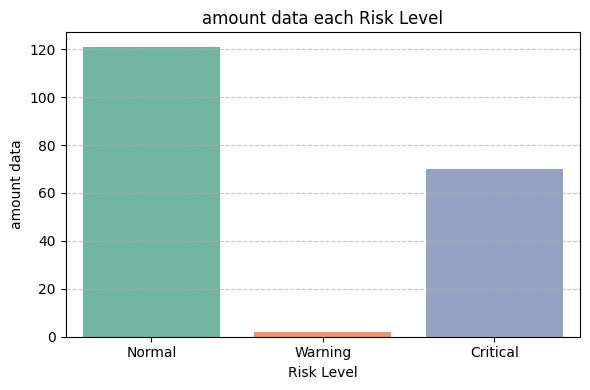

In [14]:

plt.figure(figsize=(6, 4))
sns.countplot(data=df_val, x='predicted_risk', order=['Normal', 'Warning', 'Critical'], palette='Set2')

plt.title('amount data each Risk Level')
plt.xlabel('Risk Level')
plt.ylabel('amount data')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Distribution of Anomaly Scores

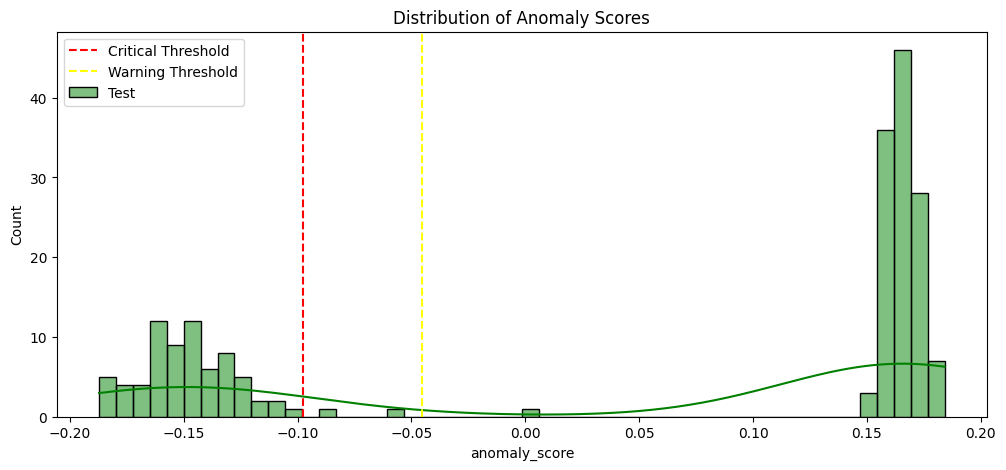

In [15]:
plt.figure(figsize=(12,5))
sns.histplot(df_val['anomaly_score'], bins=50, kde=True, color='green', label='Test')
plt.axvline(crit_thresh, color='red', linestyle='--', label='Critical Threshold')
plt.axvline(warn_thresh, color='yellow', linestyle='--', label='Warning Threshold')
plt.legend()
plt.title('Distribution of Anomaly Scores')
plt.show()



## PCA

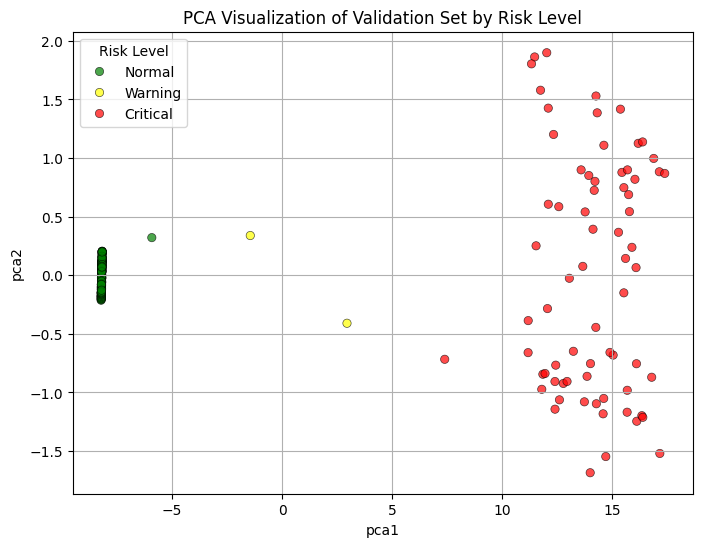

In [16]:
# Fit PCA
pca = PCA(n_components=2)
X_val_pca = pca.fit_transform(X_val_scaled)

# เพิ่มค่า PCA กลับเข้า df_val
df_val['pca1'] = X_val_pca[:, 0]
df_val['pca2'] = X_val_pca[:, 1]

# Map สีแบบกำหนดเอง
custom_palette = {
    'Normal': 'green',
    'Warning': 'yellow',
    'Critical': 'red'
}

# วาดกราฟ
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_val,
    x='pca1', y='pca2',
    hue='predicted_risk',
    palette=custom_palette,
    alpha=0.7,
    edgecolor='black'
)
plt.title('PCA Visualization of Validation Set by Risk Level')
plt.grid(True)
plt.legend(title='Risk Level')
plt.show()

In [17]:
print("\n== Mean Feature Values by Risk Level ==")
print(df_val.groupby('predicted_risk')[feature_cols].mean())


== Mean Feature Values by Risk Level ==
                     soil       rain       temp       humi        geo
predicted_risk                                                       
Critical        65.760571  34.829714  28.645286  80.617429  19.763143
Normal          48.531901   0.028926  30.004545  75.419339   4.561405
Warning         50.365000  14.000000  29.625000  78.130000  10.935000


In [18]:
print("\n== Risk Level ==")
print(df_val['predicted_risk'].value_counts())


== Risk Level ==
predicted_risk
Normal      121
Critical     70
Warning       2
Name: count, dtype: int64


## histogram

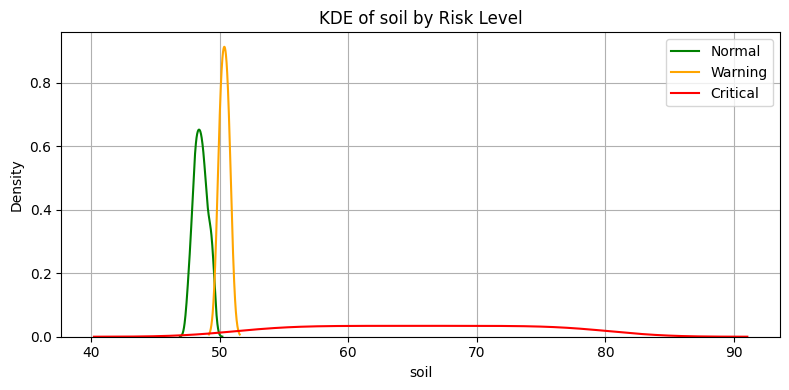

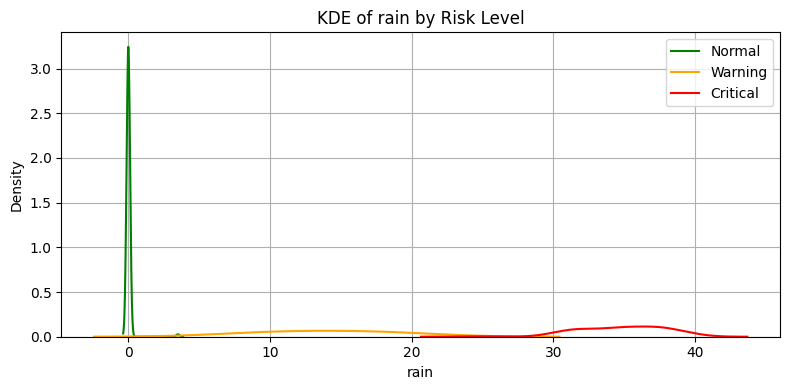

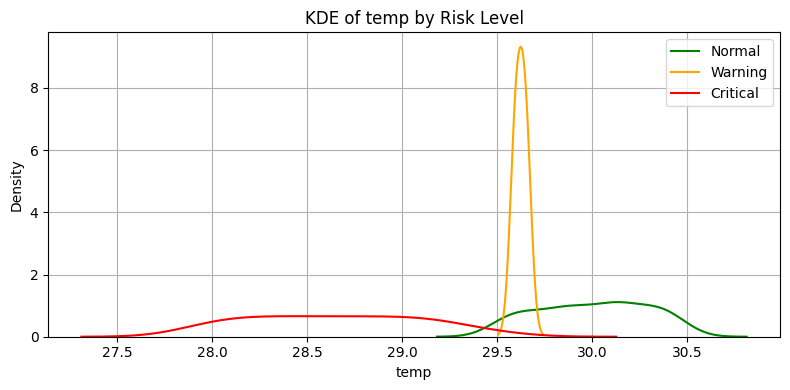

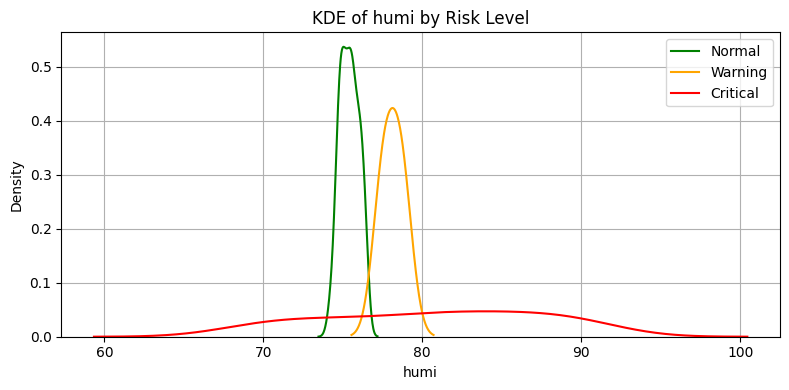

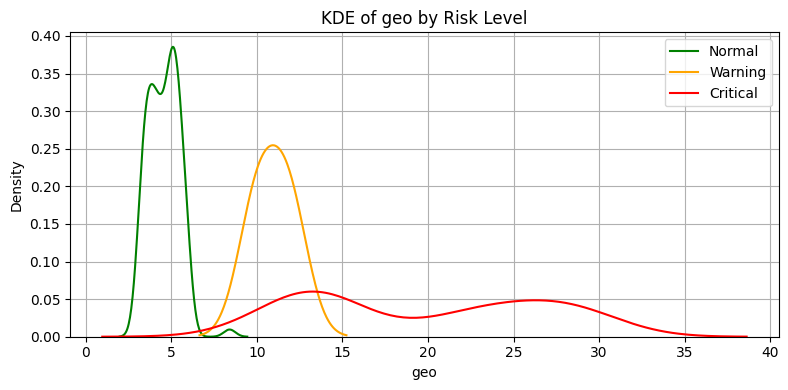

In [19]:
for col in feature_cols:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(df_val[df_val['predicted_risk'] == 'Normal'][col], label='Normal', color='green')
    sns.kdeplot(df_val[df_val['predicted_risk'] == 'Warning'][col], label='Warning', color='orange')
    sns.kdeplot(df_val[df_val['predicted_risk'] == 'Critical'][col], label='Critical', color='red')
    plt.title(f"KDE of {col} by Risk Level")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Box Plot feature by risk

C:\Users\ahmad\AppData\Local\Temp\ipykernel_20260\564551364.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\ahmad\AppData\Local\Temp\ipykernel_20260\564551364.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\ahmad\AppData\Local\Temp\ipykernel_20260\564551364.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\ahmad\AppData\Local\Temp\ipykernel_20260\564551364.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and 

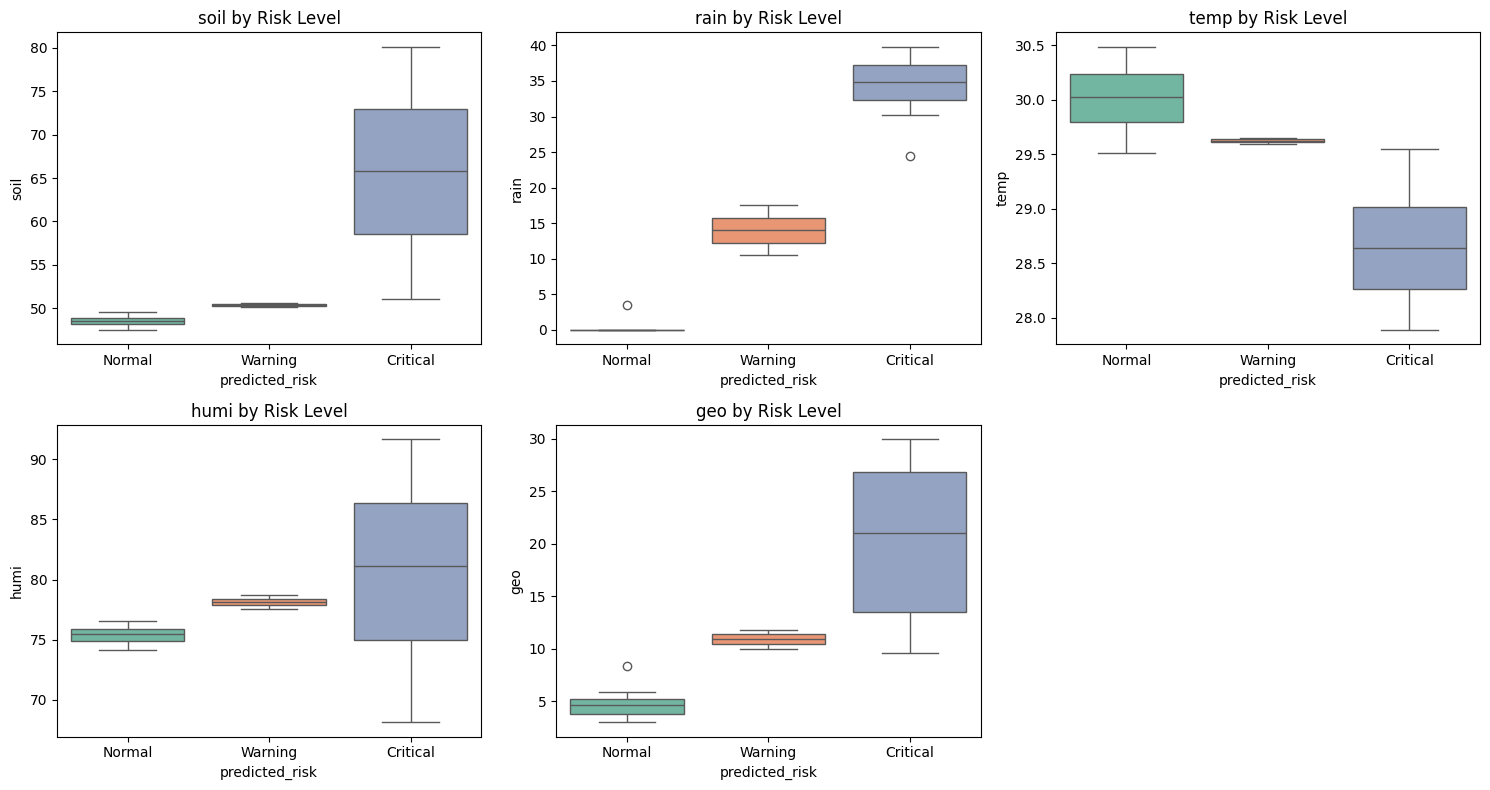

In [20]:
plt.figure(figsize=(15, 8))
for i, col in enumerate(feature_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(
        x='predicted_risk',
        y=col,
        data=df_val,
        order=['Normal', 'Warning', 'Critical'],  # 🔧 fix order here
        palette='Set2'
    )
    plt.title(f'{col} by Risk Level')
plt.tight_layout()
plt.show()


## Time Series

In [21]:
df_val['timestamp'].min()

Timestamp('2025-07-24 17:10:00')

In [22]:
df_val['timestamp'].max()

Timestamp('2025-07-24 17:42:00')

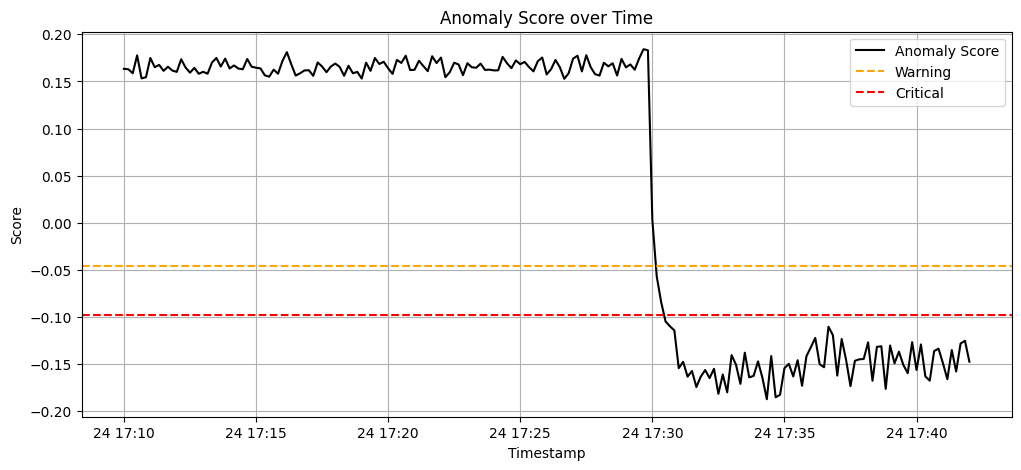

In [23]:
if 'timestamp' in df_val.columns:
    df_val['timestamp'] = pd.to_datetime(df_val['timestamp'])
    df_val_sorted = df_val.sort_values('timestamp')

    plt.figure(figsize=(12,5))
    plt.plot(df_val_sorted['timestamp'], df_val_sorted['anomaly_score'], color='black', label='Anomaly Score')
    plt.axhline(warn_thresh, color='orange', linestyle='--', label='Warning')
    plt.axhline(crit_thresh, color='red', linestyle='--', label='Critical')
    plt.title('Anomaly Score over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

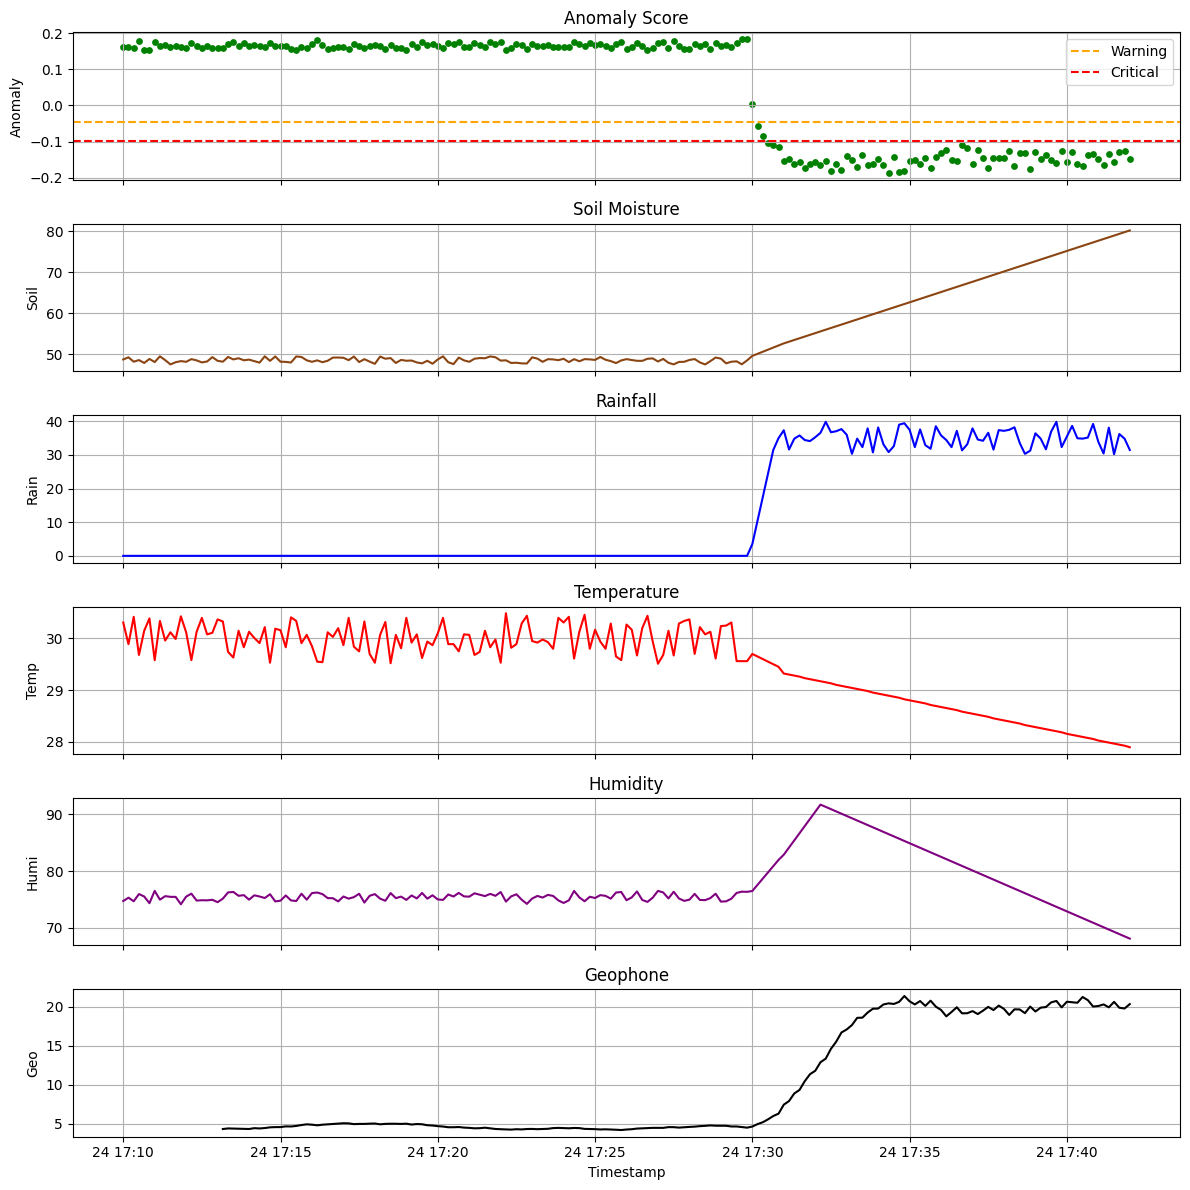

In [24]:
df_val['timestamp'] = pd.to_datetime(df_val['timestamp'])
df_dev = df_val.set_index('timestamp').sort_index()
df_range = df_dev.loc["2025-07-24":"2025-07-24"]

# สร้าง subplot 6 แถว
fig, axs = plt.subplots(6, 1, figsize=(12, 12), sharex=True)

# Plot 1: Anomaly Score
axs[0].scatter(df_range.index, df_range['anomaly_score'], color='green', s=15)
axs[0].axhline(y=warn_thresh, color='orange', linestyle='--', label='Warning')
axs[0].axhline(y=crit_thresh, color='red', linestyle='--', label='Critical')
axs[0].set_ylabel("Anomaly")
axs[0].set_title("Anomaly Score")
axs[0].legend()
axs[0].grid(True)

# Plot 2: Soil
axs[1].plot(df_range.index, df_range['soil'], color='saddlebrown')
axs[1].set_ylabel("Soil")
axs[1].set_title("Soil Moisture")
axs[1].grid(True)

# Plot 3: Rain
axs[2].plot(df_range.index, df_range['rain'], color='blue')
axs[2].set_ylabel("Rain")
axs[2].set_title("Rainfall")
axs[2].grid(True)

# Plot 4: Temp
axs[3].plot(df_range.index, df_range['temp'], color='red')
axs[3].set_ylabel("Temp")
axs[3].set_title("Temperature")
axs[3].grid(True)

# Plot 5: Humi
axs[4].plot(df_range.index, df_range['humi'], color='purple')
axs[4].set_ylabel("Humi")
axs[4].set_title("Humidity")
axs[4].grid(True)

window_size = 20  # ลองปรับค่าตามความเหมาะสม เช่น 10, 50, 100
smoothed_geo = df_range['geo'].rolling(window=window_size).mean()

axs[5].plot(df_range.index, smoothed_geo, color='black')
axs[5].set_ylabel("Geo")
axs[5].set_title("Geophone")
axs[5].grid(True)

plt.xlabel("Timestamp")
plt.tight_layout()
plt.show()


# F1-score

In [25]:

# --- 4. Prepare True Labels for Multi-Class Evaluation ---

df_val['true_label_mapped_multi'] = df_val['label'].replace({
    'critical': 'Critical', 
    'normal': 'Normal',
    'Normal': 'Normal',
    'warning':'Warning'
})

label_order = ['Critical', 'Warning', 'Normal']

df_val_filtered_multi_eval = df_val[df_val['true_label_mapped_multi'].isin(label_order)].copy()

y_true_multi = df_val_filtered_multi_eval['true_label_mapped_multi']
y_pred_multi = df_val_filtered_multi_eval['predicted_risk']

print("\nTrue Label Mapping for Multi-Class Evaluation:")
print(y_true_multi.value_counts())
print("\nPredicted Risk Label Distribution (for Multi-Class F1-score):")
print(y_pred_multi.value_counts())



True Label Mapping for Multi-Class Evaluation:
true_label_mapped_multi
Normal      121
Critical     70
Warning       2
Name: count, dtype: int64

Predicted Risk Label Distribution (for Multi-Class F1-score):
predicted_risk
Normal      121
Critical     70
Warning       2
Name: count, dtype: int64


In [26]:
# --- 5. Calculate and Print Multi-Class F1-score and other metrics ---
print("\n--- Multi-Class Model Evaluation (Normal, Warning, Critical) ---")

# For multi-class F1-score, we usually use 'weighted' or 'macro' average
# 'weighted' accounts for class imbalance
# 'macro' treats all classes equally
# 'None' gives F1-score for each class separately
f1_weighted = f1_score(y_true_multi, y_pred_multi, average='weighted', labels=label_order, zero_division=0)
f1_macro = f1_score(y_true_multi, y_pred_multi, average='macro', labels=label_order, zero_division=0)
f1_per_class = f1_score(y_true_multi, y_pred_multi, average=None, labels=label_order, zero_division=0)

print(f"\nWeighted F1-score: {f1_weighted:.4f}")
print(f"Macro F1-score: {f1_macro:.4f}")
print(f"F1-score per class ({label_order}): {f1_per_class}")


# Full classification report for multi-class
print("\nClassification Report (Multi-Class):")
# target_names should match the order of labels in y_true_multi and y_pred_multi
print(classification_report(y_true_multi, y_pred_multi, labels=label_order, target_names=label_order, zero_division=0))


# Confusion Matrix for multi-class
cm_multi = confusion_matrix(y_true_multi, y_pred_multi, labels=label_order)
print("\nConfusion Matrix (Multi-Class):")
print(cm_multi)



--- Multi-Class Model Evaluation (Normal, Warning, Critical) ---

Weighted F1-score: 1.0000
Macro F1-score: 1.0000
F1-score per class (['Critical', 'Warning', 'Normal']): [1. 1. 1.]

Classification Report (Multi-Class):
              precision    recall  f1-score   support

    Critical       1.00      1.00      1.00        70
     Warning       1.00      1.00      1.00         2
      Normal       1.00      1.00      1.00       121

    accuracy                           1.00       193
   macro avg       1.00      1.00      1.00       193
weighted avg       1.00      1.00      1.00       193


Confusion Matrix (Multi-Class):
[[ 70   0   0]
 [  0   2   0]
 [  0   0 121]]


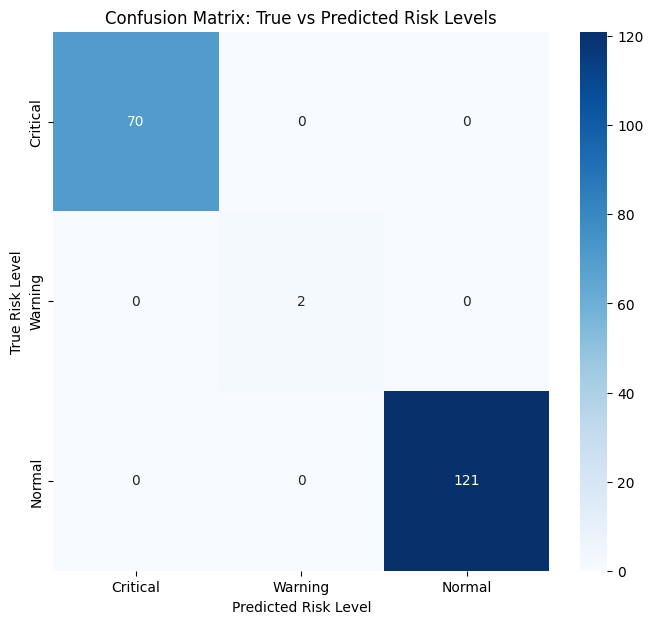

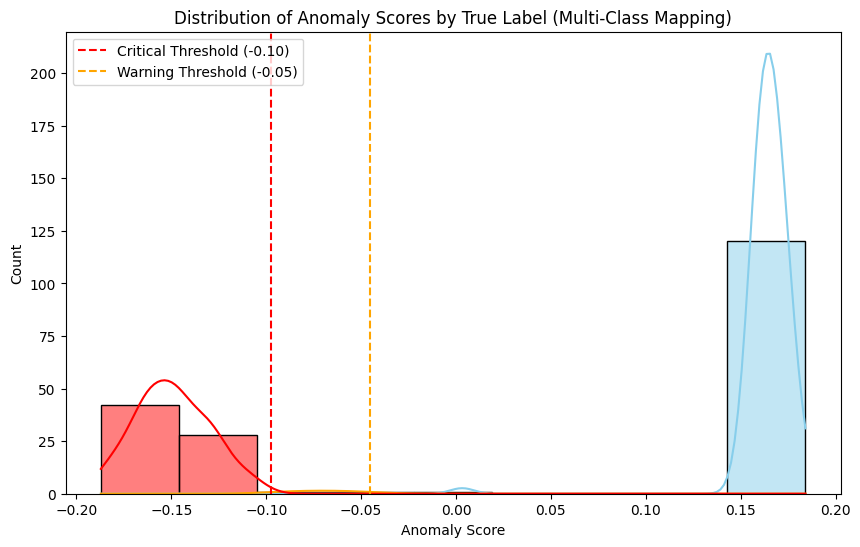

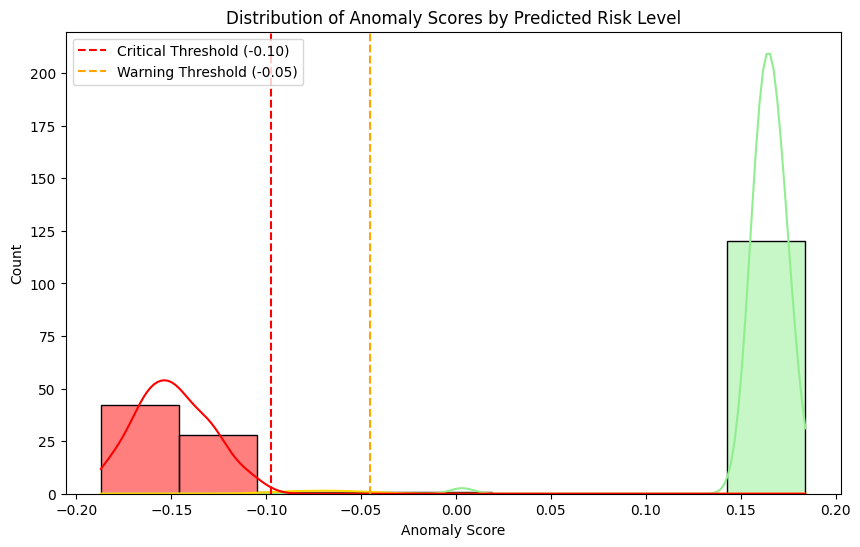

In [27]:
# Visualize Confusion Matrix for multi-class
plt.figure(figsize=(8, 7))
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_order,
            yticklabels=label_order)
plt.title('Confusion Matrix: True vs Predicted Risk Levels')
plt.xlabel('Predicted Risk Level')
plt.ylabel('True Risk Level')
plt.show()

# Visualize Anomaly Score Distribution by True Label (re-using previous plot logic)
plt.figure(figsize=(10, 6))
sns.histplot(df_val, x='anomaly_score', hue='true_label_mapped_multi', kde=True,
             palette={'Normal': 'skyblue', 'Critical': 'red', 'Warning': 'orange'}, # Adjust palette for new labels
             hue_order=label_order) # Ensure consistent order
plt.title('Distribution of Anomaly Scores by True Label (Multi-Class Mapping)')
plt.xlabel('Anomaly Score')
plt.ylabel('Count')
plt.axvline(x=crit_thresh, color='red', linestyle='--', label=f'Critical Threshold ({crit_thresh:.2f})')
plt.axvline(x=warn_thresh, color='orange', linestyle='--', label=f'Warning Threshold ({warn_thresh:.2f})')
plt.legend()
plt.show()

# Visualize Anomaly Score Distribution by Predicted Risk (already good)
plt.figure(figsize=(10, 6))
sns.histplot(df_val, x='anomaly_score', hue='predicted_risk', kde=True,
             palette={'Normal': 'lightgreen', 'Warning': 'gold', 'Critical': 'red'},
             hue_order=label_order) # Use the same order for consistency
plt.title('Distribution of Anomaly Scores by Predicted Risk Level')
plt.xlabel('Anomaly Score')
plt.ylabel('Count')
plt.axvline(x=crit_thresh, color='red', linestyle='--', label=f'Critical Threshold ({crit_thresh:.2f})')
plt.axvline(x=warn_thresh, color='orange', linestyle='--', label=f'Warning Threshold ({warn_thresh:.2f})')
plt.legend()
plt.show()